In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np

In [2]:
FOUNDATIONS = ["authority", "care", "fairness", "loyalty", "sanctity"]
COLORS = ["darkviolet", "mediumblue", "mediumseagreen", "indianred", "goldenrod"]

## Load the training and test sets

For comparison

In [3]:
data = pd.read_csv("mfd/data/mfd_scoring_results/mf_merged_roberta.csv", index_col=0)
data.drop(columns=["tokens"], inplace=True)

def get_labels_and_scores(foundation, train=False, corpus="all", ground_truth=None):
    assert corpus in ["twitter", "reddit", "news", "all"]
    if corpus == "news": data_f = data.iloc[:34262,:]
    elif corpus == "reddit": data_f = data.iloc[34262:34262 + 17886, :]
    elif corpus == "twitter": data_f = data.iloc[34262 + 17886:, :]
    else: data_f = data
    if train:
        # Labels and predicted scores for the training examples
        data_f = data_f[data_f[f"{foundation}_fold"] != 0]
        data_f = data_f[data_f[f"{foundation}_fold"] != -1]
    else:
        # Labels and predicted scores for the test examples
        data_f = data_f[data_f[f"{foundation}_fold"] == 0]
    if ground_truth is not None:
        data_f = data_f[data_f[f"{foundation}_label"] == ground_truth]
    y_true = data_f[f"{foundation}_label"]
    y_score = data_f[f"{foundation}_score"]
    return y_true, y_score

## Load external datasets

In [45]:
# Only special to the vignettes dataset
vig = pd.read_csv("mfd/other_mf_corpora/vignettes_behvres2015/data/MF_vignettes_scored.csv", index_col=0)
for f in FOUNDATIONS + ["liberty", "not wrong"]:
    x = vig[f].tolist()
    x = [int(s[:-2]) / 100 for s in x]
    vig[f] = np.array(x)
f = vig["foundation"]
f = [s.lower() for s in f]
f_new = []
for s in f:
    if "(" in s:
        idx = s.index("(")
        s = s[:idx-1]
        f_new.append(s)
    else:
        f_new.append(s)
vig["foundation"] = f_new
vig = vig[vig["foundation"] != "liberty"]
for f in FOUNDATIONS:
    y_test = vig["foundation"]
    y_test = np.array([s == f for s in y_test], dtype=int)
    vig[f] = y_test

In [49]:
paths_to_corpora = {
    "mic": "mfd/other_mf_corpora/moral_integrity_acl2022/data/MIC_without_liberty_pred.csv",
    "argument": "mfd/other_mf_corpora/moral_argument_mining_2020/data/morality_argument_pred.csv",
    "sc": "mfd/other_mf_corpora/social_chemistry_emnlp2020/data/social_chem_pred.csv",
    "vig": vig,
    "twitter_stance": "mfd/other_mf_corpora/twitter_stance_semeval2016/data/twitter_semeval2016_task6_scored.csv",
    "moral_frames": "mfd/other_mf_corpora/morality_frames_emnlp2021/data/moral_frames_dataset_roberta_annotated.csv",
    "condensed_vig": "mfd/other_mf_corpora/condensed_moral_vignettes_scan2010/data/condensed_moral_vignettes_scan2010_scored.csv",
    "jocn": "mfd/other_mf_corpora/harm_dishonesty_disgust_jocn2011/data/harm_dishonesty_disgust_dataset_scored.csv"
}
scored_corpora = {}
for k, v in paths_to_corpora.items():
    if k == "vig": 
        scored_corpora[k] = vig
    else:
        scored_corpora[k] = pd.read_csv(v)

## Comparing the distributions fo scores on the test set and on an external set 

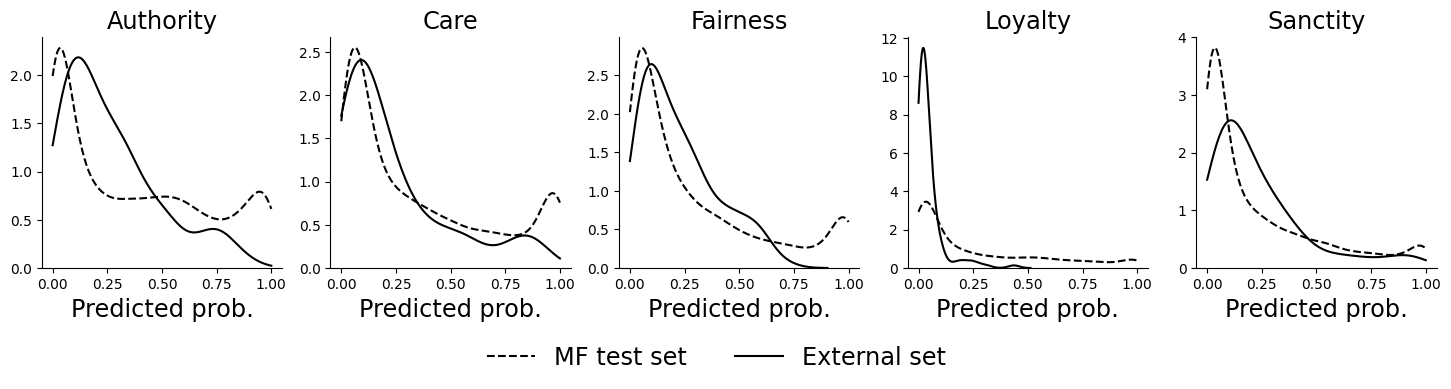

In [6]:
from matplotlib.lines import Line2D

# Change this name
corpus_name = "vig"

fig, axes = plt.subplots(1, len(FOUNDATIONS), figsize=(18, 3))
for ax, foundation, color in zip(axes, FOUNDATIONS, COLORS):
    # Get labels and predicted scores for the test set
    y_true, y_score = get_labels_and_scores(foundation, train=False)
    sns.kdeplot(y_score, ax=ax, clip=[0, 1], color="k", linestyle="--")
    ax.set_title(foundation.capitalize(), size="xx-large")
    ax.set_xlabel("Predicted prob.", size="xx-large")
    
    # Plot the same for the new dataset
    dataset = scored_corpora[corpus_name]
    y_score = dataset[foundation + "_score"]
    sns.kdeplot(y_score, ax=ax, color="k", linestyle="-", clip=[0, 1])
    ax.set_ylabel(None)

custom_lines = [Line2D([0], [0], color="k", linestyle="--"),
                Line2D([0], [0], color="k", linestyle="-")]
fig.legend(custom_lines, ['MF test set', 'External set'],
           frameon=False,
           ncol=2,
           prop={'size': "xx-large"},
           loc="lower center",
           bbox_to_anchor=(0.5, -0.3, 0, 0))
sns.despine()

## AUC

In [7]:
from sklearn.metrics import roc_auc_score

metric_df = pd.DataFrame(0, index=FOUNDATIONS, columns=["vig", "argument", "sc", "mic"])
for corpus_name in metric_df.columns:
    dataset = scored_corpora[corpus_name]
    for foundation in metric_df.index:
        y_true = dataset[foundation]
        y_score = dataset[foundation + "_score"]
        metric_df.loc[foundation, corpus_name] = roc_auc_score(y_true=y_true, y_score=y_score)

In [8]:
np.round(metric_df, 2).T

,authority,care,fairness,loyalty,sanctity
vig,0.95,0.81,0.88,0.75,0.90
argument,0.81,0.86,0.86,0.85,0.83
sc,0.73,0.70,0.74,0.80,0.69
mic,0.76,0.70,0.67,0.73,0.66


## Thresholding to get binary labels

In [9]:
from utils.evaluation import evaluate_binary_scorer_fold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from utils.calibration import inverse_calibrate_saerens
from utils.thresholding import (
    threshold_max_diff_tpr_fpr,
    threshold_max_f1,
    threshold_max_gmean,
    threshold_top_x
)

In [10]:
# Change this name
corpus_name = "sc"

metric_df = pd.DataFrame(0, index=FOUNDATIONS, columns=[95, 90, 80, 70, 60, 50])
for foundation in FOUNDATIONS:
    dataset = scored_corpora[corpus_name]
    y_true = dataset[foundation]
    y_score = dataset[foundation + "_score"]
    for percentile in metric_df.columns:
        threshold = threshold_top_x(y_score, percentile)
        y_pred = np.array([y >= threshold for y in y_score], dtype=int)
        metric_df.loc[foundation, percentile] = f1_score(y_true=y_true, y_pred=y_pred)

In [11]:
np.round(metric_df, 2)

,95,90,80,70,60,50
authority,0.28,0.35,0.34,0.31,0.28,0.26
care,0.17,0.29,0.45,0.54,0.59,0.62
fairness,0.25,0.35,0.41,0.42,0.42,0.40
loyalty,0.26,0.39,0.49,0.51,0.49,0.45
sanctity,0.25,0.25,0.23,0.21,0.19,0.18


### Using the same level and compare among datasets

In [12]:
from sklearn.metrics import f1_score

# Change this
percentile = 80

metric_df = pd.DataFrame(0, index=FOUNDATIONS, columns=["vig", "argument", "sc", "mic"])
for corpus_name in metric_df.columns:
    dataset = scored_corpora[corpus_name]
    for foundation in metric_df.index:
        y_true = dataset[foundation]
        y_score = dataset[foundation + "_score"]
        threshold = threshold_top_x(y_score, percentile)
        y_pred = np.array([y >= threshold for y in y_score], dtype=int)
        metric_df.loc[foundation, corpus_name] = f1_score(y_true=y_true, y_pred=y_pred)

In [13]:
np.round(metric_df, 2).T

,authority,care,fairness,loyalty,sanctity
vig,0.70,0.65,0.55,0.41,0.65
argument,0.50,0.57,0.55,0.33,0.54
sc,0.34,0.45,0.41,0.49,0.23
mic,0.47,0.42,0.42,0.47,0.30


## Pulling out some examples

In [14]:
# Change these
corpus_name = "vig"
text_col = "scenario"
foundation = "loyalty"
percentile = 80

dataset = scored_corpora[corpus_name]
y_true = dataset[foundation]
y_score = dataset[foundation + "_score"]
threshold = threshold_top_x(y_score, percentile)
y_pred = np.array([y >= threshold for y in y_score], dtype=int)

### True positives

In [15]:
dataset_f = dataset[(y_true == 1) & (y_pred == 1)]
# Highest-scoring first
dataset_f.sort_values(foundation + "_score", ascending=False).head(5)[text_col].tolist()

['You see a man secretly voting against his wife in a local beauty pageant.',
 'You see a US swimmer cheering as a Chinese foe beats his teammate to win the gold.',
 "You see a head cheerleader booing her high school's team during a homecoming game.",
 'You see a former Secretary of State publicly giving up his citizenship to the US.',
 "You see a Hollywood star agreeing with a foreign dictator's denunciation of the US."]

### True negatives

In [16]:
dataset_f = dataset[(y_true == 0) & (y_pred == 0)]
# Lowest-scoring first
dataset_f.sort_values(foundation + "_score", ascending=True).head(5)[text_col].tolist()

['You see someone driving around in a dirty car that has not been washed recently.',
 'You see someone reading the ending of a spy novel before reading the beginning.',
 'You see someone at the school gym lifting free weights in nice business clothes.',
 'You see a college student drinking until she vomits on herself and falls asleep.',
 'You see someone using an old rotary phone and refusing to go buy a new one.']

### False positives

In [17]:
dataset_f = dataset[(y_true == 0) & (y_pred == 1)]
# Highest-scoring first
dataset_f.sort_values(foundation + "_score", ascending=False).head(5)[text_col].tolist()

['You see a man turn his back and walk away while his boss questions his work.',
 'You see someone cheating in a card game while playing with a group of strangers.',
 'You see a woman throwing a stapler at her colleague who is snoring during her talk.',
 'You see a teenage girl openly staring at a disfigured woman as she walks past.',
 'You see a man snickering as he passes by a cancer patient with a bald head.']

### False negatives

In [18]:
dataset_f = dataset[(y_true == 1) & (y_pred == 0)]
# Lowest-scoring first
dataset_f.sort_values(foundation + "_score", ascending=True).head(5)[text_col].tolist()

['You see a mayor saying that the neighboring town is a much better town.',
 'You see an employee joking with competitors about how bad his company did last year.',
 'You see a teacher publicly saying she hopes another school wins the math contest.',
 'You see the US Ambassador joking in Great Britain about the stupidity of Americans.',
 'You see the class president saying on TV that her rival college is a better school.']

## Evaluation of different scoring methods

In [68]:
from sklearn.metrics import roc_auc_score
corpora = ["vig", "argument", "sc", "mic"]
methods = ["mfd", "mfd2", "emfd", "ddr", "roberta"]
aucs = {name: {corpus: {"authority": 0, "care": 0, "fairness": 0, "loyalty": 0, "sanctity": 0}
               for corpus in corpora}
        for name in methods}

In [69]:
# Vignettes
for name in methods:
    n = "scored" if name == "roberta" else "scored_" + name
    scores = pd.read_csv(f"mfd/other_mf_corpora/vignettes_behvres2015/data/MF_vignettes_{n}.csv", index_col=0)
    
    scores = scores.loc[vig.index]
    
    for foundation in FOUNDATIONS:
        y_true = vig[foundation].to_numpy()
        y_score = scores[foundation + ("_score" if name in ["roberta", "ddr"] else "")].to_numpy()
        aucs[name]["vig"][foundation] = roc_auc_score(y_true=y_true, y_score=y_score)

In [70]:
# Arguments
for name in methods:
    n = "pred" if name == "roberta" else "scored_" + name
    scores = pd.read_csv(f"mfd/other_mf_corpora/moral_argument_mining_2020/data/morality_argument_{n}.csv", index_col=0)
    
    for foundation in FOUNDATIONS:
        y_true = scored_corpora["argument"][foundation].to_numpy()
        y_score = scores[foundation + ("_score" if name in ["roberta", "ddr"] else "")].to_numpy()
        aucs[name]["argument"][foundation] = roc_auc_score(y_true=y_true, y_score=y_score)

In [71]:
# Social chemistry
for name in methods:
    n = "pred" if name == "roberta" else "scored_" + name
    scores = pd.read_csv(f"mfd/other_mf_corpora/social_chemistry_emnlp2020/data/social_chem_{n}.csv", index_col=0)
    
    for foundation in FOUNDATIONS:
        y_true = scored_corpora["sc"][foundation].to_numpy()
        y_score = scores[foundation + ("_score" if name in ["roberta", "ddr"] else "")].to_numpy()
        aucs[name]["sc"][foundation] = roc_auc_score(y_true=y_true, y_score=y_score)

In [72]:
# Moral integrity corpus
for name in methods:
    n = "pred" if name == "roberta" else "scored_" + name
    scores = pd.read_csv(f"mfd/other_mf_corpora/moral_integrity_acl2022/data/MIC_without_liberty_{n}.csv", index_col=0)
    
    for foundation in FOUNDATIONS:
        y_true = scored_corpora["mic"][foundation].to_numpy()
        y_score = scores[foundation + ("_score" if name in ["roberta", "ddr"] else "")].to_numpy()
        aucs[name]["mic"][foundation] = roc_auc_score(y_true=y_true, y_score=y_score)

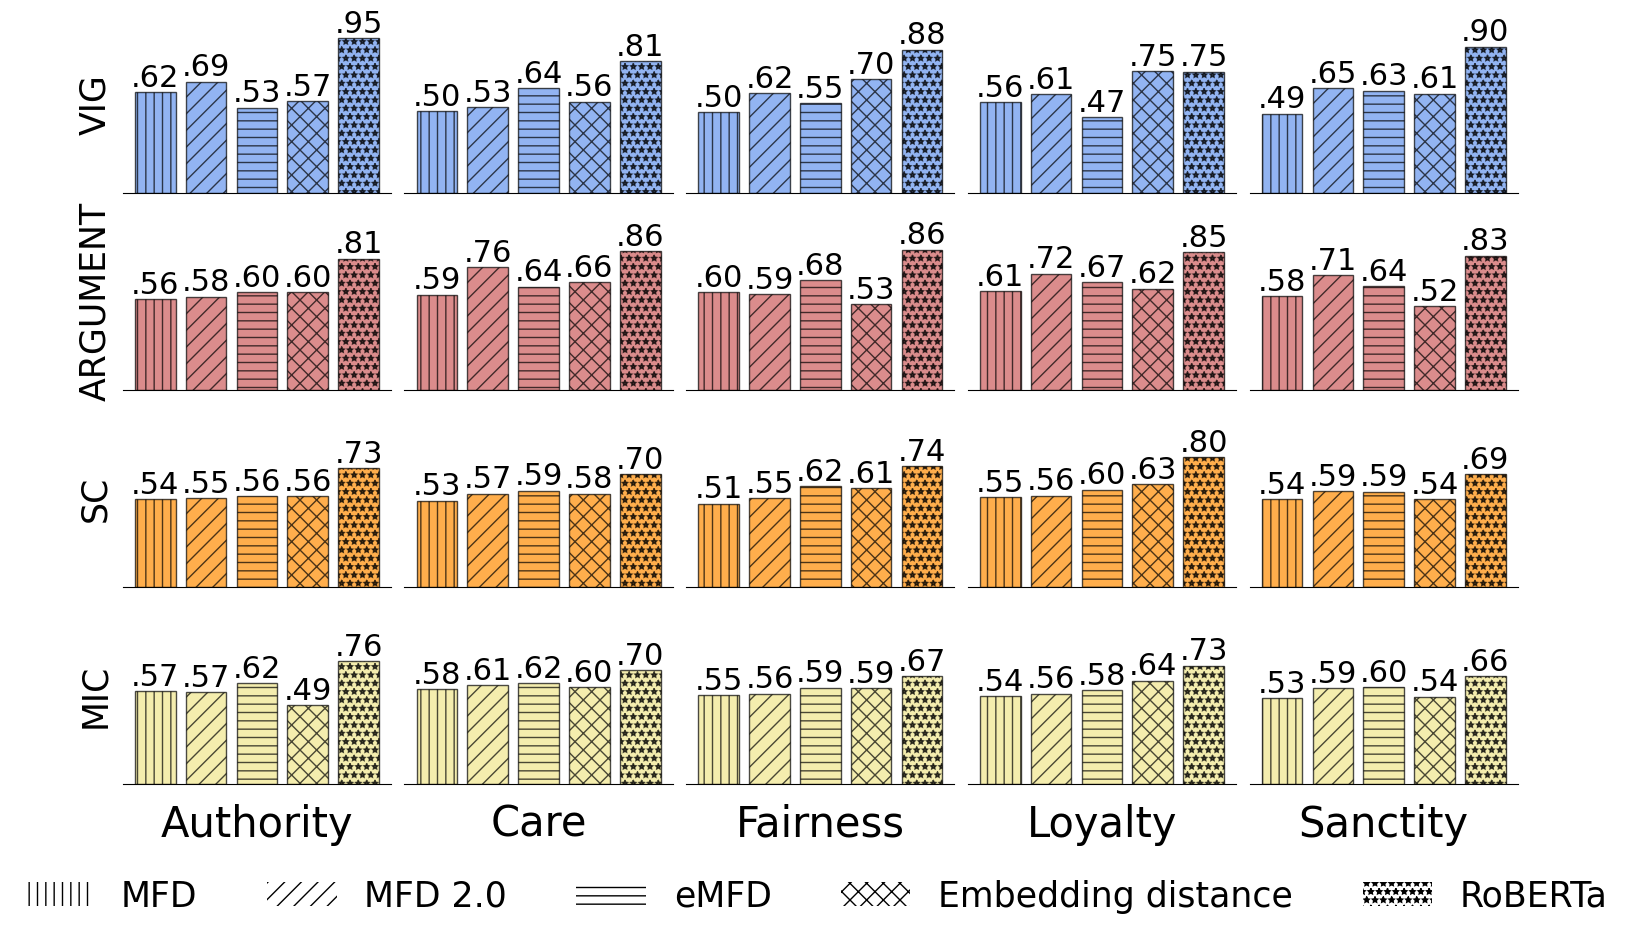

In [85]:
from matplotlib.patches import Patch

fig, axes = plt.subplots(4, 5, figsize=(18, 10))
corpora_colors = ["cornflowerblue", "indianred", "darkorange", "khaki"]
for i, (corpus, axes0, background) in enumerate(zip(corpora, axes, corpora_colors)):
    for j, (ax, foundation) in enumerate(zip(axes0, FOUNDATIONS)):
        # MFD2, eMFD, DDR, RoBERTa
        methods = ["mfd", "mfd2", "emfd", "ddr", "roberta"]
        hist = [aucs[method][corpus][foundation] for method in methods]
        bars = ax.bar(np.arange(len(methods)), hist, edgecolor="black", color=background, alpha=0.7)
        ax.set_ylim([0, 1.1])
        hatches = ["||", "//", "--", "xx", "**"]
        for k, (bar, val, hatch) in enumerate(zip(bars, hist, hatches)):
            s = str(round(val, 2))[1:]
            if len(s) < 3: s += "0"
            ax.text(x=k, y=val, s=s, size=22, va="bottom", ha="center")
            bar.set_hatch(hatch)
        ax.set_xticks([])
        ax.set_yticks([])
        if i > 1:
            ax.set_xlabel(foundation.capitalize(), size=30, labelpad=10)
        sns.despine(top=True, right=True, left=k > 0, ax=ax)
    axes0[0].set_ylabel(corpus.upper(), size=25)

plt.subplots_adjust(wspace=0.05, hspace=0.1)

legend_elements = [Patch(facecolor='none', edgecolor='black', hatch="||", label="MFD", linewidth=0),
                   Patch(facecolor='none', edgecolor='black', hatch="//", label="MFD 2.0", linewidth=0),
                   Patch(facecolor='none', edgecolor='black', hatch="--", label="eMFD", linewidth=0),
                   Patch(facecolor='none', edgecolor='black', hatch="xx", label="Embedding distance", linewidth=0),
                   Patch(facecolor='none', edgecolor='black', hatch="**", label="RoBERTa", linewidth=0),
                   ]
fig.legend(handles=legend_elements,
           frameon=False,
           ncol=5,
           prop={'size': 25},
           loc="lower center",
           bbox_to_anchor=(0.51, -0.05, 0, 0))

plt.show()